
## import

In [22]:
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from datasets_prep.dataset import create_dataset
from diffusion import sample_from_model, sample_posterior, \
    q_sample_pairs, get_time_schedule, \
    Posterior_Coefficients, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf
import wandb

## utils

In [23]:
def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward()

In [24]:
from EMA import EMA
from score_sde.models.discriminator import Discriminator_large, Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp, WaveletNCSNpp

torch.manual_seed(args.seed + rank)
torch.cuda.manual_seed(args.seed + rank)
torch.cuda.manual_seed_all(args.seed + rank)
device = torch.device('cuda:{}'.format(gpu))

batch_size = args.batch_size

nz = args.nz  # latent dimension

dataset = create_dataset(args)
#train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
#                                                                num_replicas=args.world_size,
#                                                                rank=rank)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=args.num_workers,
                                          pin_memory=True,
                                          #sampler=train_sampler,
                                          drop_last=True)
args.ori_image_size = args.image_size
args.image_size = args.current_resolution
G_NET_ZOO = {"normal": NCSNpp, "wavelet": WaveletNCSNpp}
gen_net = G_NET_ZOO[args.net_type]
disc_net = [Discriminator_small, Discriminator_large]
print("GEN: {}, DISC: {}".format(gen_net, disc_net))
netG = gen_net(args).to(device)

if args.dataset in ['cifar10', 'stl10']:
    netD = disc_net[0](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)
else:
    netD = disc_net[1](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)

#broadcast_params(netG.parameters())
#broadcast_params(netD.parameters())

optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters(
)), lr=args.lr_d, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad, netG.parameters(
)), lr=args.lr_g, betas=(args.beta1, args.beta2))

if args.use_ema:
    optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerG, args.num_epoch, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerD, args.num_epoch, eta_min=1e-5)

# ddp
#netG = nn.parallel.DistributedDataParallel(
#    netG, device_ids=[gpu], find_unused_parameters=True)
#netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])

"""############### DELETE TO AVOID ERROR ###############"""
# Wavelet Pooling
#if not args.use_pytorch_wavelet:
#    dwt = DWT_2D("haar")
#    iwt = IDWT_2D("haar")
#else:
#    dwt = DWTForward(J=1, mode='zero', wave='haar').cuda()
#    iwt = DWTInverse(mode='zero', wave='haar').cuda()
    

#load encoder and decoder
config_path = args.AutoEncoder_config 
ckpt_path = args.AutoEncoder_ckpt 

if args.dataset in ['cifar10', 'stl10', 'coco']:

    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    
    AutoEncoder = instantiate_from_config(config['model'])
    

    checkpoint = torch.load(ckpt_path, map_location=device)
    AutoEncoder.load_state_dict(checkpoint['state_dict'])
    AutoEncoder.eval()
    AutoEncoder.to(device)

else:
    AutoEncoder = load_model_from_config(config_path, ckpt_path)
"""############### END DELETING ###############"""

num_levels = int(np.log2(args.ori_image_size // args.current_resolution))

exp = args.exp
parent_dir = "./saved_info/{}".format(args.dataset)

exp_path = os.path.join(parent_dir, exp)
if rank == 0:
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        copy_source(__file__, exp_path)
        shutil.copytree('score_sde/models', os.path.join(exp_path, 'score_sde/models'))

coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

if args.resume or os.path.exists(os.path.join(exp_path, 'content.pth')):
    checkpoint_file = os.path.join(exp_path, 'content.pth')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    init_epoch = checkpoint['epoch']
    epoch = init_epoch
    # load G
    netG.load_state_dict(checkpoint['netG_dict'])
    #optimizerG.load_state_dict(checkpoint['optimizerG'])
    schedulerG.load_state_dict(checkpoint['schedulerG'])
    # load D
    netD.load_state_dict(checkpoint['netD_dict'])
    #optimizerD.load_state_dict(checkpoint['optimizerD'])
    schedulerD.load_state_dict(checkpoint['schedulerD'])

    global_step = checkpoint['global_step']
    print("=> loaded checkpoint (epoch {})"
          .format(checkpoint['epoch']))
else:
    global_step, epoch, init_epoch = 0, 0, 0

'''Sigmoid learning parameter'''
gamma = 6
beta = np.linspace(-gamma, gamma, args.num_epoch+1)
alpha = 1 - 1 / (1+np.exp(-beta))

for epoch in range(init_epoch, args.num_epoch + 1):
    #train_sampler.set_epoch(epoch)
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for iteration, (x, y) in enumerate(data_loader):
        for p in netD.parameters():
            p.requires_grad = True
        netD.zero_grad()

        for p in netG.parameters():
            p.requires_grad = False

        # sample from p(x_0)
        x0 = x.to(device, non_blocking=True)

        """################# Change here: Encoder #################"""
        with torch.no_grad():
            posterior = AutoEncoder.encode(x0)
            real_data = posterior.sample().detach()
        #print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
        real_data = real_data / args.scale_factor #300.0  # [-1, 1]
        
        
        #assert -1 <= real_data.min() < 0
        #assert 0 < real_data.max() <= 1
        """################# End change: Encoder #################"""

        # sample t
        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)

        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
        x_t.requires_grad = True

        # train with real
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)
        errD_real = F.softplus(-D_real).mean()

        errD_real.backward(retain_graph=True)

        if args.lazy_reg is None:
            grad_penalty_call(args, D_real, x_t)
        else:
            if global_step % args.lazy_reg == 0:
                grad_penalty_call(args, D_real, x_t)

        # train with fake
        latent_z = torch.randn(batch_size, nz, device=device)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errD_fake = F.softplus(output).mean()

        errD_fake.backward()

        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # update G
        for p in netD.parameters():
            p.requires_grad = False

        for p in netG.parameters():
            p.requires_grad = True
        netG.zero_grad()

        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

        latent_z = torch.randn(batch_size, nz, device=device)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errG = F.softplus(-output).mean()

        # reconstructior loss
        if args.sigmoid_learning and args.rec_loss:
            ######alpha
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + alpha[epoch]*rec_loss

        elif args.rec_loss and not args.sigmoid_learning:
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + rec_loss
        

        errG.backward()
        optimizerG.step()

        global_step += 1
        if iteration % 100 == 0:
            if rank == 0:
                end.record()
                torch.cuda.synchronize()
                elapsed_time = start.elapsed_time(end)
                if args.sigmoid_learning:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, alpha: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), alpha[epoch]))
                elif args.rec_loss:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, rec_loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), rec_loss.item()))
                else:   
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item()))
                wandb.log({"iteration:": iteration, "G_loss": errG.item(), "D_loss": errD.item(), "alpha": alpha[epoch], "elapsed_time": elapsed_time / 1000})
                start.record()

    if not args.no_lr_decay:

        schedulerG.step()
        schedulerD.step()

    if rank == 0:
        ########################################
        x_t_1 = torch.randn_like(posterior.sample())
        fake_sample = sample_from_model(
            pos_coeff, netG, args.num_timesteps, x_t_1, T, args)

        """############## CHANGE HERE: DECODER ##############"""
        fake_sample *= args.scale_factor #300
        real_data *= args.scale_factor #300
        with torch.no_grad():
            fake_sample = AutoEncoder.decode(fake_sample)
            real_data = AutoEncoder.decode(real_data)
        
        fake_sample = (torch.clamp(fake_sample, -1, 1) + 1) / 2  # 0-1
        real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 
        
        """############## END HERE: DECODER ##############"""

        torchvision.utils.save_image(fake_sample, os.path.join(
            exp_path, 'sample_discrete_epoch_{}.png'.format(epoch)))
        torchvision.utils.save_image(
            real_data, os.path.join(exp_path, 'real_data.png'))

        if args.save_content:
            if epoch % args.save_content_every == 0:
                print('Saving content.')
                content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                           'netG_dict': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                           'schedulerG': schedulerG.state_dict(), 'netD_dict': netD.state_dict(),
                           'optimizerD': optimizerD.state_dict(), 'schedulerD': schedulerD.state_dict()}
                torch.save(content, os.path.join(exp_path, 'content.pth'))

        if epoch % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(
                exp_path, 'netG_{}.pth'.format(epoch)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)
                

## wandb setting


In [29]:
wandb.init(
            project="LDGAN",
            config={
                "dataset": args.dataset,
                "image_size": args.image_size,
                "channels": args.num_channels,
                "timesteps": args.num_timesteps,
                "nz": args.nz,
                "epochs": args.num_epoch,
                "ngf": args.ngf,
                "lr_g": args.lr_g,
                "lr_d": args.lr_d,
                "batch_size": args.batch_size,
                "r1_gamma": args.r1_gamma,
                "lazy_reg": args.lazy_reg,
                "use_ema": args.use_ema,
                "ema_decay": args.ema_decay,
                "no_lr_decay": args.no_lr_decay,
                "use_pytorch_wavelet": args.use_pytorch_wavelet,
                "rec_loss": args.rec_loss,
                "net_type": args.net_type,
                "num_disc_layers": args.num_disc_layers,
                "no_use_fbn": args.no_use_fbn,
                "no_use_freq": args.no_use_freq,
                "no_use_residual": args.no_use_residual,
                "scale_factor": args.scale_factor,
                "AutoEncoder_config": args.AutoEncoder_config,
                "AutoEncoder_ckpt": args.AutoEncoder_ckpt,
                "sigmoid_learning": args.sigmoid_learning,
            }
        )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kotomiya07. Use `wandb login --relogin` to force relogin


## config

In [74]:
from get_args import get_args
args = [
    "--dataset", "coco", "--image_size", "256",
    "--exp", "g1222_128_2block_d4_attn16_nz50_64", "--num_channels", "3",
    "--num_channels_dae", "128", "--ch_mult", "1", "2", "2", "2", 
    "--num_timesteps", "2", "--num_res_blocks", "2", 
    "--batch_size", "8", "--num_epoch", "200", 
    "--ngf", "64", "--embedding_type", "positional", 
    "--use_ema", "--ema_decay", "0.999",
    "--r1_gamma", "2.", "--nz", "100",
    "--z_emb_dim", "256", "--lr_d", "1.0e-4",
    "--lr_g", "2e-4", "--lazy_reg", "10",
    "--save_content", "--datadir", "data/coco", 
    "--master_port", "6084", "--num_process_per_node", "0",
    "--current_resolution", "64", "--attn_resolution", "16",
    "--num_disc_layers", "4", "--rec_loss", 
    "--save_content_every", "1", "--AutoEncoder_config", "./autoencoder/config/COCO_config.yaml", 
    "--AutoEncoder_ckpt", "./autoencoder/weight/kl-f4.ckpt", "--scale_factor", "6.0", 
    "--no_lr_decay", "--sigmoid_learning"
]

args = get_args(args)


## train


In [75]:
rank = 0
gpu = 0

from EMA import EMA
from score_sde.models.discriminator import Discriminator_large, Discriminator_small
from score_sde.models.ncsnpp_generator_adagn import NCSNpp, WaveletNCSNpp

torch.manual_seed(args.seed + rank)
torch.cuda.manual_seed(args.seed + rank)
torch.cuda.manual_seed_all(args.seed + rank)
device = torch.device('cuda:{}'.format(gpu))

batch_size = args.batch_size

nz = args.nz  # latent dimension

dataset = create_dataset(args)
#train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
#                                                                num_replicas=args.world_size,
#                                                                rank=rank)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=args.num_workers,
                                          pin_memory=True,
                                          #sampler=train_sampler,
                                          drop_last=True)
args.ori_image_size = args.image_size
args.image_size = args.current_resolution
G_NET_ZOO = {"normal": NCSNpp, "wavelet": WaveletNCSNpp}
gen_net = G_NET_ZOO[args.net_type]
disc_net = [Discriminator_small, Discriminator_large]
print("GEN: {}, DISC: {}".format(gen_net, disc_net))
netG = gen_net(args).to(device)

if args.dataset in ['cifar10', 'stl10']:
    netD = disc_net[0](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)
else:
    netD = disc_net[1](nc=2 * args.num_channels, ngf=args.ngf,
                       t_emb_dim=args.t_emb_dim,
                       act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)

#broadcast_params(netG.parameters())
#broadcast_params(netD.parameters())

optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters(
)), lr=args.lr_d, betas=(args.beta1, args.beta2))
optimizerG = optim.Adam(filter(lambda p: p.requires_grad, netG.parameters(
)), lr=args.lr_g, betas=(args.beta1, args.beta2))

if args.use_ema:
    optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerG, args.num_epoch, eta_min=1e-5)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizerD, args.num_epoch, eta_min=1e-5)

# ddp
#netG = nn.parallel.DistributedDataParallel(
#    netG, device_ids=[gpu], find_unused_parameters=True)
#netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])

"""############### DELETE TO AVOID ERROR ###############"""
# Wavelet Pooling
#if not args.use_pytorch_wavelet:
#    dwt = DWT_2D("haar")
#    iwt = IDWT_2D("haar")
#else:
#    dwt = DWTForward(J=1, mode='zero', wave='haar').cuda()
#    iwt = DWTInverse(mode='zero', wave='haar').cuda()
    

#load encoder and decoder
config_path = args.AutoEncoder_config 
ckpt_path = args.AutoEncoder_ckpt 

if args.dataset in ['cifar10', 'stl10', 'coco']:

    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    
    AutoEncoder = instantiate_from_config(config['model'])
    

    checkpoint = torch.load(ckpt_path, map_location=device)
    AutoEncoder.load_state_dict(checkpoint['state_dict'])
    AutoEncoder.eval()
    AutoEncoder.to(device)

else:
    AutoEncoder = load_model_from_config(config_path, ckpt_path)
"""############### END DELETING ###############"""

num_levels = int(np.log2(args.ori_image_size // args.current_resolution))

exp = args.exp
parent_dir = "./saved_info/{}".format(args.dataset)

exp_path = os.path.join(parent_dir, exp)
if rank == 0:
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        copy_source(__file__, exp_path)
        shutil.copytree('score_sde/models', os.path.join(exp_path, 'score_sde/models'))

coeff = Diffusion_Coefficients(args, device)
pos_coeff = Posterior_Coefficients(args, device)
T = get_time_schedule(args, device)

if args.resume or os.path.exists(os.path.join(exp_path, 'content.pth')):
    checkpoint_file = os.path.join(exp_path, 'content.pth')
    checkpoint = torch.load(checkpoint_file, map_location=device)
    init_epoch = checkpoint['epoch']
    epoch = init_epoch
    # load G
    netG.load_state_dict(checkpoint['netG_dict'])
    #optimizerG.load_state_dict(checkpoint['optimizerG'])
    schedulerG.load_state_dict(checkpoint['schedulerG'])
    # load D
    netD.load_state_dict(checkpoint['netD_dict'])
    #optimizerD.load_state_dict(checkpoint['optimizerD'])
    schedulerD.load_state_dict(checkpoint['schedulerD'])

    global_step = checkpoint['global_step']
    print("=> loaded checkpoint (epoch {})"
          .format(checkpoint['epoch']))
else:
    global_step, epoch, init_epoch = 0, 0, 0

'''Sigmoid learning parameter'''
gamma = 6
beta = np.linspace(-gamma, gamma, args.num_epoch+1)
alpha = 1 - 1 / (1+np.exp(-beta))

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
GEN: <class 'score_sde.models.ncsnpp_generator_adagn.NCSNpp'>, DISC: [<class 'score_sde.models.discriminator.Discriminator_small'>, <class 'score_sde.models.discriminator.Discriminator_large'>]
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [66]:
from PIL import Image

In [67]:
tmp = iter(data_loader)
x, y = next(tmp)

In [68]:
x[0].shape
y

['a woman in camouflage saluting with a teddy bear ',
 'Woman holding skis wearing tank top and ski gear.',
 'A bathroom has a self standing sink on the wall.',
 "The black cat is playing with someone's foot.",
 'A living room space is displayed with stained glass.',
 'A large white plane is parked at the gate.',
 'A bus sits next to a bus stop.',
 'A pizza that is laying down on a table.']

The black cat is playing with someone's foot.


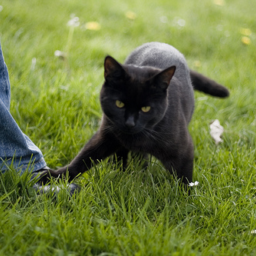

In [69]:
real_data = (torch.clamp(x[3], -1, 1) + 1) / 2  # 0-1 

torchvision.utils.save_image(
    real_data, os.path.join("./", 'real_data.png'))
imgPIL = Image.open("./real_data.png")  # 画像読み込み

print(y[3])
imgPIL.show()  # 画像表示

In [71]:
for p in netD.parameters():
    p.requires_grad = True
netD.zero_grad()

for p in netG.parameters():
    p.requires_grad = False

# sample from p(x_0)
x0 = x.to(device, non_blocking=True)

"""################# Change here: Encoder #################"""
with torch.no_grad():
    posterior = AutoEncoder.encode(x0)
    real_data = posterior.sample().detach()
#print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
real_data = real_data / args.scale_factor #300.0  # [-1, 1]


#assert -1 <= real_data.min() < 0
#assert 0 < real_data.max() <= 1
"""################# End change: Encoder #################"""

# sample t
t = torch.randint(0, args.num_timesteps,
                  (real_data.size(0),), device=device)

x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
x_t.requires_grad = True

# train with real
D_real = netD(x_t, t, x_tp1.detach()).view(-1)
errD_real = F.softplus(-D_real).mean()

errD_real.backward(retain_graph=True)

if args.lazy_reg is None:
    grad_penalty_call(args, D_real, x_t)
else:
    if global_step % args.lazy_reg == 0:
        grad_penalty_call(args, D_real, x_t)

# train with fake
latent_z = torch.randn(batch_size, nz, device=device)
x_0_predict = netG(x_tp1.detach(), t, latent_z)
x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
errD_fake = F.softplus(output).mean()

errD_fake.backward()

errD = errD_real + errD_fake
# Update D
optimizerD.step()

# update G
for p in netD.parameters():
    p.requires_grad = False

for p in netG.parameters():
    p.requires_grad = True
netG.zero_grad()

t = torch.randint(0, args.num_timesteps,
                  (real_data.size(0),), device=device)
x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

latent_z = torch.randn(batch_size, nz, device=device)
x_0_predict = netG(x_tp1.detach(), t, latent_z)
x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
errG = F.softplus(-output).mean()

# reconstructior loss
if args.sigmoid_learning and args.rec_loss:
    ######alpha
    rec_loss = F.l1_loss(x_0_predict, real_data)
    errG = errG + alpha[epoch]*rec_loss

elif args.rec_loss and not args.sigmoid_learning:
    rec_loss = F.l1_loss(x_0_predict, real_data)
    errG = errG + rec_loss


errG.backward()
optimizerG.step()

## train loop

In [76]:
for epoch in range(init_epoch, args.num_epoch + 1):
    #train_sampler.set_epoch(epoch)
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for iteration, (x, y) in enumerate(data_loader):
        if iteration % 10 == 0:
            print("iteration: {}".format(iteration))
        for p in netD.parameters():
            p.requires_grad = True
        netD.zero_grad()

        for p in netG.parameters():
            p.requires_grad = False

        # sample from p(x_0)
        x0 = x.to(device, non_blocking=True)

        """################# Change here: Encoder #################"""
        with torch.no_grad():
            posterior = AutoEncoder.encode(x0)
            real_data = posterior.sample().detach()
        #print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
        real_data = real_data / args.scale_factor #300.0  # [-1, 1]
        
        
        #assert -1 <= real_data.min() < 0
        #assert 0 < real_data.max() <= 1
        """################# End change: Encoder #################"""

        # sample t
        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)

        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
        x_t.requires_grad = True

        # train with real
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)
        errD_real = F.softplus(-D_real).mean()

        errD_real.backward(retain_graph=True)

        if args.lazy_reg is None:
            grad_penalty_call(args, D_real, x_t)
        else:
            if global_step % args.lazy_reg == 0:
                grad_penalty_call(args, D_real, x_t)

        # train with fake
        latent_z = torch.randn(batch_size, nz, device=device)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errD_fake = F.softplus(output).mean()

        errD_fake.backward()

        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # update G
        for p in netD.parameters():
            p.requires_grad = False

        for p in netG.parameters():
            p.requires_grad = True
        netG.zero_grad()

        t = torch.randint(0, args.num_timesteps,
                          (real_data.size(0),), device=device)
        x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

        latent_z = torch.randn(batch_size, nz, device=device)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

        output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
        errG = F.softplus(-output).mean()

        # reconstructior loss
        if args.sigmoid_learning and args.rec_loss:
            ######alpha
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + alpha[epoch]*rec_loss

        elif args.rec_loss and not args.sigmoid_learning:
            rec_loss = F.l1_loss(x_0_predict, real_data)
            errG = errG + rec_loss
        

        errG.backward()
        optimizerG.step()

        global_step += 1
        if iteration % 100 == 0:
            if rank == 0:
                end.record()
                torch.cuda.synchronize()
                elapsed_time = start.elapsed_time(end)
                if args.sigmoid_learning:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, alpha: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), alpha[epoch]))
                elif args.rec_loss:
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}, rec_loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item(), rec_loss.item()))
                else:   
                    print('epoch {} iteration{}, G Loss: {}, D Loss: {}'.format(
                        epoch, iteration, errG.item(), errD.item()))
                wandb.log({"iteration:": iteration, "G_loss": errG.item(), "D_loss": errD.item(), "alpha": alpha[epoch], "elapsed_time": elapsed_time / 1000})
                start.record()

    if not args.no_lr_decay:

        schedulerG.step()
        schedulerD.step()

    if rank == 0:
        ########################################
        x_t_1 = torch.randn_like(posterior.sample())
        fake_sample = sample_from_model(
            pos_coeff, netG, args.num_timesteps, x_t_1, T, args)

        """############## CHANGE HERE: DECODER ##############"""
        fake_sample *= args.scale_factor #300
        real_data *= args.scale_factor #300
        with torch.no_grad():
            fake_sample = AutoEncoder.decode(fake_sample)
            real_data = AutoEncoder.decode(real_data)
        
        fake_sample = (torch.clamp(fake_sample, -1, 1) + 1) / 2  # 0-1
        real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 
        
        """############## END HERE: DECODER ##############"""

        torchvision.utils.save_image(fake_sample, os.path.join(
            exp_path, 'sample_discrete_epoch_{}.png'.format(epoch)))
        torchvision.utils.save_image(
            real_data, os.path.join(exp_path, 'real_data.png'))

        if args.save_content:
            if epoch % args.save_content_every == 0:
                print('Saving content.')
                content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                           'netG_dict': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                           'schedulerG': schedulerG.state_dict(), 'netD_dict': netD.state_dict(),
                           'optimizerD': optimizerD.state_dict(), 'schedulerD': schedulerD.state_dict()}
                torch.save(content, os.path.join(exp_path, 'content.pth'))

        if epoch % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(
                exp_path, 'netG_{}.pth'.format(epoch)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(
                    store_params_in_ema=True)

iteration: 0
epoch 0 iteration0, G Loss: 133.19500732421875, D Loss: 1.3043075799942017, alpha: 0.9975273768433652
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 6

KeyboardInterrupt: 